In [ ]:
#Instalamos la librerias necesarias (solo la primera vez que ejecutamos el script)
!pip install -r requirements.txt

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import shap
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression

In [2]:
df=pd.read_csv("https://breathecode.herokuapp.com/asset/internal-link?id=927&path=AB_NYC_2019.csv")
df.rename(columns={"availability_365": "days_available", "calculated_host_listings_count": "lodging"}, inplace=True)
df.set_index("id",inplace=True)
df.head(5)

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,lodging,days_available
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# **1. CRIBADO MANUAL**

## 1.1. Eliminación columnas con valores únicos

In [3]:
#Valores unicos por cada columna
unicos=df.nunique()
unicos[unicos==1]

Series([], dtype: int64)

Podemos observar como no haya variables con un unico valor que no aporten información al futuro modelo predictivo. Aunque vamos a revisar aquellas columnas con un reducido número de valores únicos.

## 1.2. Eliminación de filas y columnas duplicadas

In [4]:
#Indice
dup_fil=df.duplicated().sum()
print("No hay filas duplicadas" if dup_fil==0 else "Hay filas duplicadas")

No hay filas duplicadas


In [5]:
#Trasponemos las columnas para verificar que toda la fila (variable) no sea igual a otra
dup_col=df.T.duplicated(keep=False).sum()
print("No hay variables exactamente iguales" if dup_col==0 else "Hay variables exactamente iguales")

No hay variables exactamente iguales


## 1.3. Eliminación de variables redundantes

Identificadores por anfitrión y apartamentos

In [6]:
#Calculamos el numero de valores unicos por host_id: si solo hay 1, las variables son redundantes
host_name_por_id = df.groupby('host_id')['host_name'].nunique()
print("host_id con >1 host_name:", (host_name_por_id > 1).sum())

host_id con >1 host_name: 0


[]

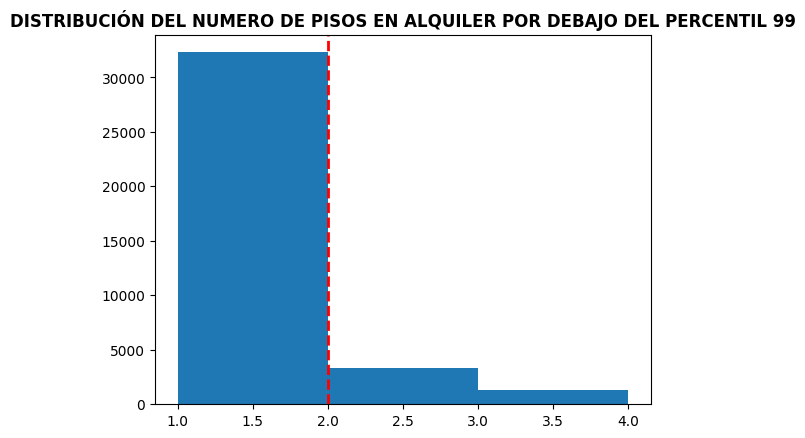

In [7]:
pisos=df["host_id"].value_counts()
plt.hist(pisos[pisos<pisos.quantile(0.99)].astype("int"), bins="auto") #Nº de anuncios por debajo del percentil
plt.axvline(2, color='red', linestyle='--', linewidth=2)
plt.title("Distribución del numero de pisos en alquiler por debajo del percentil 99".upper(), fontweight="bold")
plt.plot()

Vamos a crear dos variables: nº alojamientos ofertados y si el individuo ofertante es profesional (n>2)

In [8]:
#Hoster profesional
prof=df['host_id'].map(lambda x: 1 if pisos.get(x, 0) >= 2 else 0)
posicion = df.columns.get_loc('host_id')
df.insert(posicion+1, 'host_prof', prof)
df.head(2)

,name,host_id,host_prof,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,lodging,days_available
id,,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,1,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,1,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [9]:
name_por_id = df.groupby('id')['name'].nunique()
print("id con >1 name:", (name_por_id > 1).sum())

id con >1 name: 0


In [10]:
aloj=df.index.value_counts().sum()
print("No hay alojamientos que aparecen más de una vez" if aloj==df.shape[0] else "Hay alojamientos duplicadas")

No hay alojamientos que aparecen más de una vez


In [11]:
#Eliminamos host name
df.drop(columns=["host_name", "host_id","name"], axis=1, inplace=True)

## 1.3. Estudio de missing values

In [12]:
# Columnas columnas con más de un 15% de valores faltantes
missing=df.isna().mean()*100
missing[missing>15]

last_review          20.558339
reviews_per_month    20.558339
dtype: float64

## 1.4. Limpieza y Variables categorias

Las unicas dos variables con valores faltantes son ```last_review``` y ```reviews_per_month```. Vamos a analizar si hay algún patron común.

In [13]:
df[["number_of_reviews","last_review","reviews_per_month"]][df["last_review"].isna()]

,number_of_reviews,last_review,reviews_per_month
id,,,
3647,0,NaN,NaN
7750,0,NaN,NaN
8700,0,NaN,NaN
11452,0,NaN,NaN
11943,0,NaN,NaN
...,...,...,...
36484665,0,NaN,NaN
36485057,0,NaN,NaN
36485431,0,NaN,NaN


<Axes: >

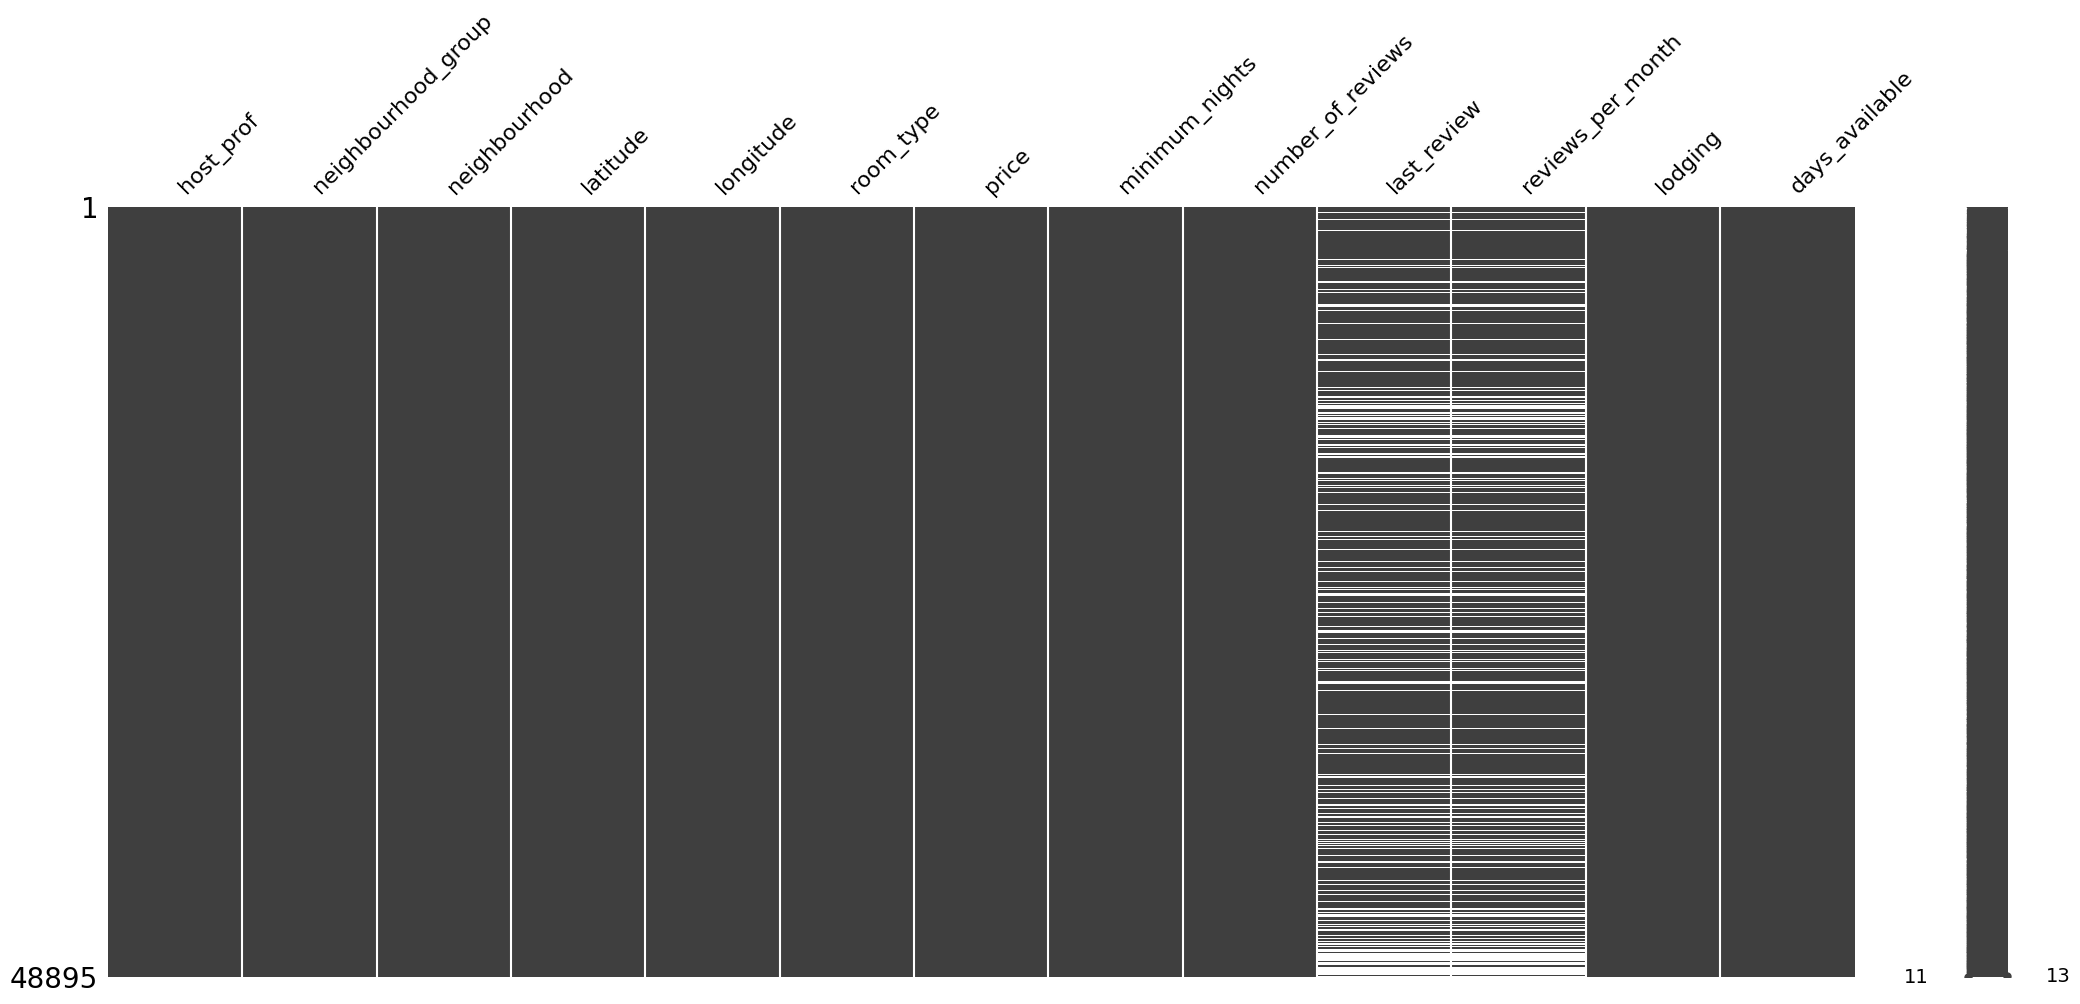

In [14]:
# Gráficamente
msno.matrix(df)

In [15]:
#Reseñas al mes iguales a 0
df['reviews_per_month'] = pd.to_numeric(df['reviews_per_month'], errors='coerce')
df['reviews_per_month'].fillna(0, inplace=True)
df[df['reviews_per_month'].isna()]

C:\Users\jjime\AppData\Local\Temp\ipykernel_9572\3103072898.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_per_month'].fillna(0, inplace=True)


,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,lodging,days_available
id,,,,,,,,,,,,,


In [16]:
# Pasamos la columna a datetime para poder trabajar con ella 
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce') #errors --> maneja valores no YY/MM/dd
# Creamos la fecha de la utima reseña posible
## Establecemos como ultima fecha 2 dias de margen sobre la fecha mas cercana
today = df['last_review'].sort_values(ascending=False).iloc[0]+ pd.Timedelta(days=2)
df['days_since_review'] = (today - df['last_review']).dt.days
#Eliminamos la columna fecha
df.drop(columns=["last_review"], axis=1, inplace=True)
df.head(2)

,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,lodging,days_available,days_since_review
id,,,,,,,,,,,,,
2539,1,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,264.0
2595,1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,50.0


### A) Grupos de barrios

In [17]:
df.groupby("neighbourhood_group")["price"].mean().sort_values().reset_index()

,neighbourhood_group,price
0,Bronx,87.496792
1,Queens,99.517649
2,Staten Island,114.812332
3,Brooklyn,124.383207
4,Manhattan,196.875814


In [18]:
#Creamos un df ordenando lor barrios por su precio medio
orden1=df.groupby("neighbourhood_group")["price"].mean().sort_values().reset_index()#Pasamos la serie a df
#Creamos un ranking de menor a mayor precio
orden1["cat"]=orden1["price"].rank().astype(int)
#Eliminamos el precio del df y establecemos indice para crear el diccionario objetivo
dicc1=orden1.drop(columns=["price"]).set_index("neighbourhood_group").to_dict()["cat"]
dicc1

{'Bronx': 1, 'Queens': 2, 'Staten Island': 3, 'Brooklyn': 4, 'Manhattan': 5}

In [19]:
#Sutituimos los valores en el df
df["neighbourhood_group"]=df["neighbourhood_group"].replace(dicc1).astype("category")
df.head(2)

C:\Users\jjime\AppData\Local\Temp\ipykernel_9572\2812608512.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["neighbourhood_group"]=df["neighbourhood_group"].replace(dicc1).astype("category")


,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,lodging,days_available,days_since_review
id,,,,,,,,,,,,,
2539,1,4,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,264.0
2595,1,5,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,50.0


### B) Barrios

In [20]:
df.groupby("neighbourhood")["price"].mean().sort_values().reset_index()

,neighbourhood,price
0,Bull's Head,47.333333
1,Hunts Point,50.500000
2,Tremont,51.545455
3,Soundview,53.466667
4,New Dorp,57.000000
...,...,...
216,Riverdale,442.090909
217,Sea Gate,487.857143
218,Tribeca,490.638418
219,Woodrow,700.000000


In [21]:
#Creamos un df ordenando los barrios por su precio medio
orden2=df.groupby("neighbourhood")["price"].mean().sort_values().reset_index()
#Creamos un ranking de menor a mayor precio
orden2["cat"]=orden2["price"].rank().astype(int)
dicc2=orden2.drop(columns=["price"]).set_index("neighbourhood").to_dict()["cat"]
dicc2

{"Bull's Head": 1,
 'Hunts Point': 2,
 'Tremont': 3,
 'Soundview': 4,
 'New Dorp': 5,
 'Bronxdale': 6,
 'New Dorp Beach': 7,
 'Grant City': 8,
 'Concord': 9,
 'Mount Eden': 10,
 'Corona': 11,
 'Woodlawn': 12,
 'Castle Hill': 13,
 'Borough Park': 14,
 'Olinville': 15,
 'Woodhaven': 16,
 'Arden Heights': 17,
 'Emerson Hill': 18,
 'Graniteville': 19,
 'Parkchester': 20,
 'Schuylerville': 21,
 'Morris Park': 22,
 'Fordham': 23,
 'University Heights': 24,
 'Silver Lake': 25,
 'Highbridge': 26,
 'Westerleigh': 27,
 'Concourse Village': 28,
 'Rossville': 29,
 'Fieldston': 30,
 'Little Neck': 31,
 'Baychester': 32,
 'Norwood': 33,
 'Bensonhurst': 34,
 'New Springville': 35,
 'Tompkinsville': 36,
 'Brownsville': 37,
 'Rosedale': 38,
 'Morris Heights': 39,
 'Belmont': 40,
 'Ridgewood': 41,
 'Co-op City': 42,
 'Mount Hope': 42,
 'Kingsbridge': 44,
 'Richmondtown': 45,
 'Gravesend': 46,
 'Dongan Hills': 47,
 'Port Morris': 48,
 'North Riverdale': 49,
 'Midwood': 50,
 'Elmhurst': 51,
 'West Brighto

In [22]:
#Sutituimos los valores en el df
df["neighbourhood"]=df["neighbourhood"].replace(dicc2).astype("category")
df.head(2)

C:\Users\jjime\AppData\Local\Temp\ipykernel_9572\1461765114.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["neighbourhood"]=df["neighbourhood"].replace(dicc2).astype("category")


,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,lodging,days_available,days_since_review
id,,,,,,,,,,,,,
2539,1,4,93,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,264.0
2595,1,5,210,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,50.0


### C) Tipo de habitación

In [23]:
df.groupby("room_type")["price"].mean().sort_values().reset_index()

,room_type,price
0,Shared room,70.127586
1,Private room,89.780973
2,Entire home/apt,211.794246


In [24]:
#Creamos un df ordenando los barrios por su precio medio
orden3=df.groupby("room_type")["price"].mean().sort_values().reset_index()
#Creamos un ranking de menor a mayor precio
orden3["cat"]=orden3["price"].rank().astype(int)
dicc3=orden3.drop(columns=["price"]).set_index("room_type").to_dict()["cat"]
dicc3

{'Shared room': 1, 'Private room': 2, 'Entire home/apt': 3}

In [25]:
#Sutituimos los valores en el df
df["room_type"]=df["room_type"].replace(dicc3).astype("category")
df.head(2)

C:\Users\jjime\AppData\Local\Temp\ipykernel_9572\3597542359.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["room_type"]=df["room_type"].replace(dicc3).astype("category")


,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,lodging,days_available,days_since_review
id,,,,,,,,,,,,,
2539,1,4,93,40.64749,-73.97237,2,149,1,9,0.21,6,365,264.0
2595,1,5,210,40.75362,-73.98377,3,225,1,45,0.38,2,355,50.0


## Train-Test Split

In [28]:
X = df.drop('price',axis=1)
y = df['price']

In [29]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42) #random_state establece una semilla para que la division aleatoria sea la misma

In [30]:
X_train.head()

,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,lodging,days_available,days_since_review
id,,,,,,,,,,,,
25674366,0,4,158,40.71577,-73.95530,3,3,11,0.87,1,1,55.0
19100971,0,5,86,40.84917,-73.94048,2,2,2,0.16,1,0,380.0
24209867,1,4,121,40.68993,-73.95947,2,2,0,0.00,2,0,NaN
22451798,0,4,121,40.68427,-73.93118,3,3,87,4.91,1,267,5.0
5344850,0,2,70,40.74705,-73.89564,2,5,13,0.25,1,0,204.0


## Imputación de missing values

In [ ]:
df[["days_since_review", "host_prof", "latitude", "longitude", "price", "minimum_nights", "number_of_reviews"]].corr()["days_since_review"]

In [ ]:
'''impute_knn=KNNImputer(n_neighbors=2)
df_imp=impute_knn.fit_transform(df[["host_prof", "number_of_reviews", "days_since_review"]]) #seleccionamos las dos variables más correlacionadas

df_imp=pd.DataFrame(df_imp, columns=["host_prof", "number_of_reviews", "days_since_review"])

df_imp["days_since_review"].isnull().sum() '''

In [ ]:
df[df["last_review"].isna()].head(2)

## 2.2. Outliers

In [31]:
columns=["lodging", "host_prof", "neighbourhood_group", "neighbourhood", "latitude", "longitude", "room_type", "minimum_nights", "number_of_reviews", "reviews_per_month", "days_since_review", "days_available"]
X_train[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
lodging,39116.0,7.188925,33.172629,1.00000,1.000000,1.000000,2.000000,327.00000
host_prof,39116.0,0.339554,0.473564,0.00000,0.000000,0.000000,1.000000,1.00000
latitude,39116.0,40.728927,0.054555,40.49979,40.690067,40.723035,40.763180,40.91306
longitude,39116.0,-73.952311,0.046029,-74.24285,-73.983080,-73.955750,-73.936498,-73.71299
minimum_nights,39116.0,7.144775,21.472973,1.00000,1.000000,3.000000,5.000000,1250.00000
number_of_reviews,39116.0,23.334978,44.499352,0.00000,1.000000,5.000000,24.000000,629.00000
reviews_per_month,39116.0,1.094376,1.604249,0.00000,0.040000,0.370000,1.590000,58.50000
days_since_review,31010.0,277.330087,413.495354,2.00000,17.000000,51.000000,360.000000,2998.00000
days_available,39116.0,113.445368,131.846430,0.00000,0.000000,46.000000,229.000000,365.00000


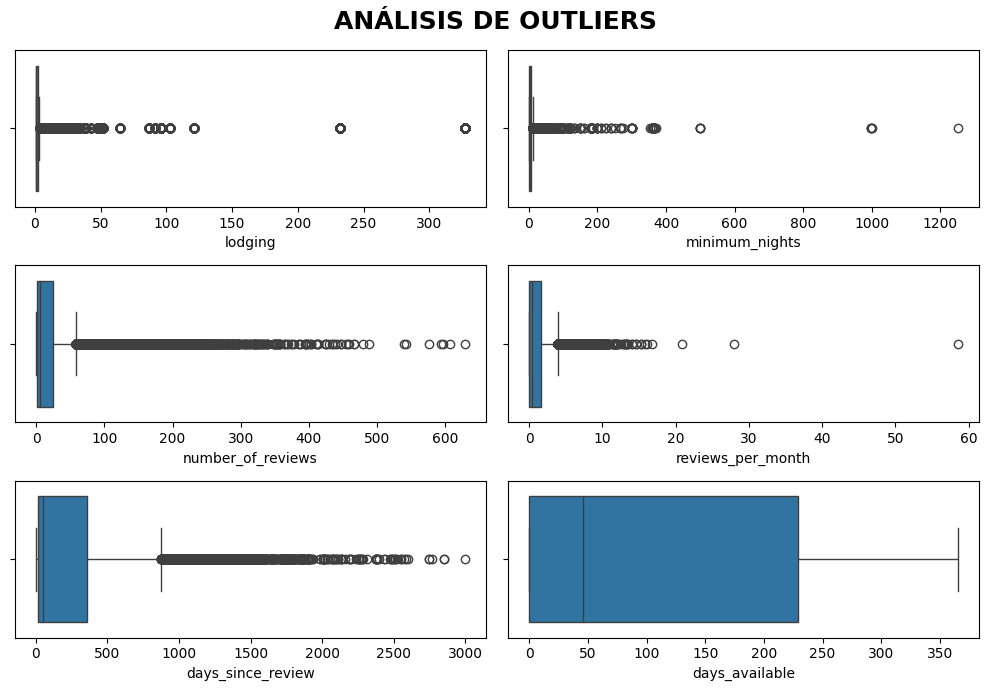

In [32]:
fig, axis = plt.subplots(3, 2, figsize = (10, 7))

# Crear una figura múltiple con histogramas y diagramas de caja
sns.boxplot(ax = axis[0, 0], data = X_train, x = "lodging")
sns.boxplot(ax = axis[0, 1],data = X_train, x = "minimum_nights")
sns.boxplot(ax = axis[1, 0],data = X_train, x = "number_of_reviews")
sns.boxplot(ax = axis[1, 1],data = X_train, x = "reviews_per_month")
sns.boxplot(ax = axis[2, 0],data = X_train, x = "days_since_review")
sns.boxplot(ax = axis[2, 1],data = X_train, x = "days_available")
fig.suptitle("Análisis de Outliers".upper(), size=18, fontweight="bold")
# Ajustar el layout
plt.tight_layout()
# Mostrar el plot
plt.show()

In [ ]:
iso = IsolationForest(random_state=123)
df_num = X_train.copy()
df_num['outlier_flag'] = iso.fit_predict(X_train)

In [ ]:
df_num['outlier_flag'].value_counts(normalize=True)*100

In [ ]:
df_num[df_num['outlier_flag']==1].describe().T.round(2)

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_num[df_num['outlier_flag']==-1].describe().T.round(2)

# **2. SELECCIÓN DE CARCATERÍSTICAS**

## 2.1. Aplicación de los métodos

### A) Feature importance con Random Forest

In [34]:
# Entrenamiento de RF
model = RandomForestRegressor(random_state=42,n_jobs=-1).fit(X_train, y_train)

In [35]:
# Importancia de características
importances = model.feature_importances_*100

# Convertir a DataFrame
df_rf = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

# Calculamos la importancia acumulada
df_rf['rf_importance_acum'] = df_rf['rf_importance'].cumsum()
df_rf

,feature,rf_importance,rf_importance_acum
3,latitude,19.544494,19.544494
4,longitude,18.373400,37.917894
11,days_since_review,12.341118,50.259012
10,days_available,10.661420,60.920433
2,neighbourhood,9.819581,70.740013
6,minimum_nights,8.762401,79.502414
5,room_type,6.186384,85.688799
9,lodging,5.576940,91.265738
8,reviews_per_month,4.195046,95.460784
7,number_of_reviews,3.155249,98.616033


### B) Permutation/Shuffle importance con XGBRegressor 

In [ ]:
'''X_train[["neighbourhood_group", "neighbourhood", "room_type"]]=X_train[["neighbourhood_group", "neighbourhood", "room_type"]].astype("category")

# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror',enable_categorical=True ,random_state=42).fit(X_train1, y_train1)'''

In [53]:
#Carm
X_train[["neighbourhood_group", "neighbourhood", "room_type"]]=X_train[["neighbourhood_group", "neighbourhood", "room_type"]].astype("int")

In [54]:
# Para esta técnica y la de shap se necesita conjunto de validación
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Ajustamos el modelo
model_xgb = XGBRegressor(objective='reg:squarederror', random_state=42).fit(X_train1, y_train1)

In [66]:
# Realizamos 10 permutaciones por cada característica
perm = permutation_importance(model_xgb, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
df_perm = pd.DataFrame({'feature': X_train.columns, 'perm': perm.importances_mean*100}).sort_values('perm', ascending=False)
df_perm

,feature,perm
2,neighbourhood,41.695669
5,room_type,35.311712
8,reviews_per_month,29.981743
7,number_of_reviews,22.493084
11,days_since_review,22.184288
4,longitude,16.943247
3,latitude,14.174346
9,lodging,14.106964
6,minimum_nights,12.065570
10,days_available,11.792300


### C) SHAP

In [59]:
# Ajustamos el modelo
model_lgbm = lgb.LGBMRegressor(random_state=42, n_jobs=-1).fit(X_train1, y_train1)

explainer = shap.Explainer(model_lgbm, X_val)   # usa el mismo X_val
shap_vals = explainer(X_val).values

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 31292, number of used features: 12
[LightGBM] [Info] Start training from score 153.698581


 97%|=================== | 7568/7824 [00:25<00:00]       

In [73]:
imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap = pd.DataFrame({"feature": X_val.columns, "shap": imp_shap_pct}).sort_values('shap', ascending=False)
df_shap

,feature,shap
5,room_type,26.149318
2,neighbourhood,16.504049
10,days_available,12.873142
11,days_since_review,12.498410
6,minimum_nights,8.444125
8,reviews_per_month,6.230009
9,lodging,4.364933
7,number_of_reviews,4.315724
4,longitude,3.964960
3,latitude,3.562169


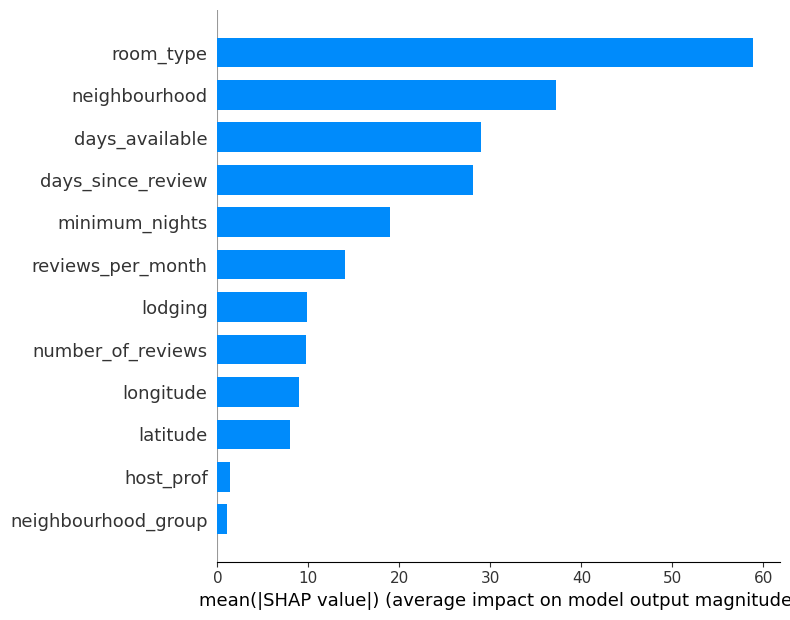

In [63]:
# Resumen gráfico de barras
shap.summary_plot(shap_vals, X_val, plot_type="bar")

## 2.2. Selección de característica según los 3 métodos

In [78]:
df_importances = (
    df_rf
    .merge(df_perm, on='feature', how='outer')
    .merge(df_shap, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_acum,perm,shap
3,latitude,19.544494,19.544494,14.174346,3.562169
5,longitude,18.373400,37.917894,16.943247,3.964960
1,days_since_review,12.341118,50.259012,22.184288,12.498410
0,days_available,10.661420,60.920433,11.792300,12.873142
7,neighbourhood,9.819581,70.740013,41.695669,16.504049
6,minimum_nights,8.762401,79.502414,12.065570,8.444125
11,room_type,6.186384,85.688799,35.311712,26.149318
4,lodging,5.576940,91.265738,14.106964,4.364933
10,reviews_per_month,4.195046,95.460784,29.981743,6.230009
9,number_of_reviews,3.155249,98.616033,22.493084,4.315724


In [82]:
#Filtrado
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm']>=1)&(df_importances['shap']>=1)]
df_filt

,feature,rf_importance,rf_importance_acum,perm,shap
3,latitude,19.544494,19.544494,14.174346,3.562169
5,longitude,18.373400,37.917894,16.943247,3.964960
1,days_since_review,12.341118,50.259012,22.184288,12.498410
0,days_available,10.661420,60.920433,11.792300,12.873142
7,neighbourhood,9.819581,70.740013,41.695669,16.504049
6,minimum_nights,8.762401,79.502414,12.065570,8.444125
11,room_type,6.186384,85.688799,35.311712,26.149318
4,lodging,5.576940,91.265738,14.106964,4.364933
10,reviews_per_month,4.195046,95.460784,29.981743,6.230009
9,number_of_reviews,3.155249,98.616033,22.493084,4.315724


## 2.3. Comprobación vif y correlaciones

In [80]:
features = df_filt['feature']
features

3              latitude
5             longitude
1     days_since_review
0        days_available
7         neighbourhood
6        minimum_nights
11            room_type
4               lodging
10    reviews_per_month
9     number_of_reviews
Name: feature, dtype: object

In [94]:
vif = pd.Series([variance_inflation_factor(X_train[features].corr().values, i) for i in range(X_train[features].corr().shape[1])], index=X_train[features].columns)
df_vif = pd.Series(vif, name='vif').reset_index().rename(columns={'index': 'feature'})
df_vif[df_vif["vif"]>4]

,feature,vif
1,longitude,5.198080
4,neighbourhood,5.852946
8,reviews_per_month,6.722898
9,number_of_reviews,4.714037


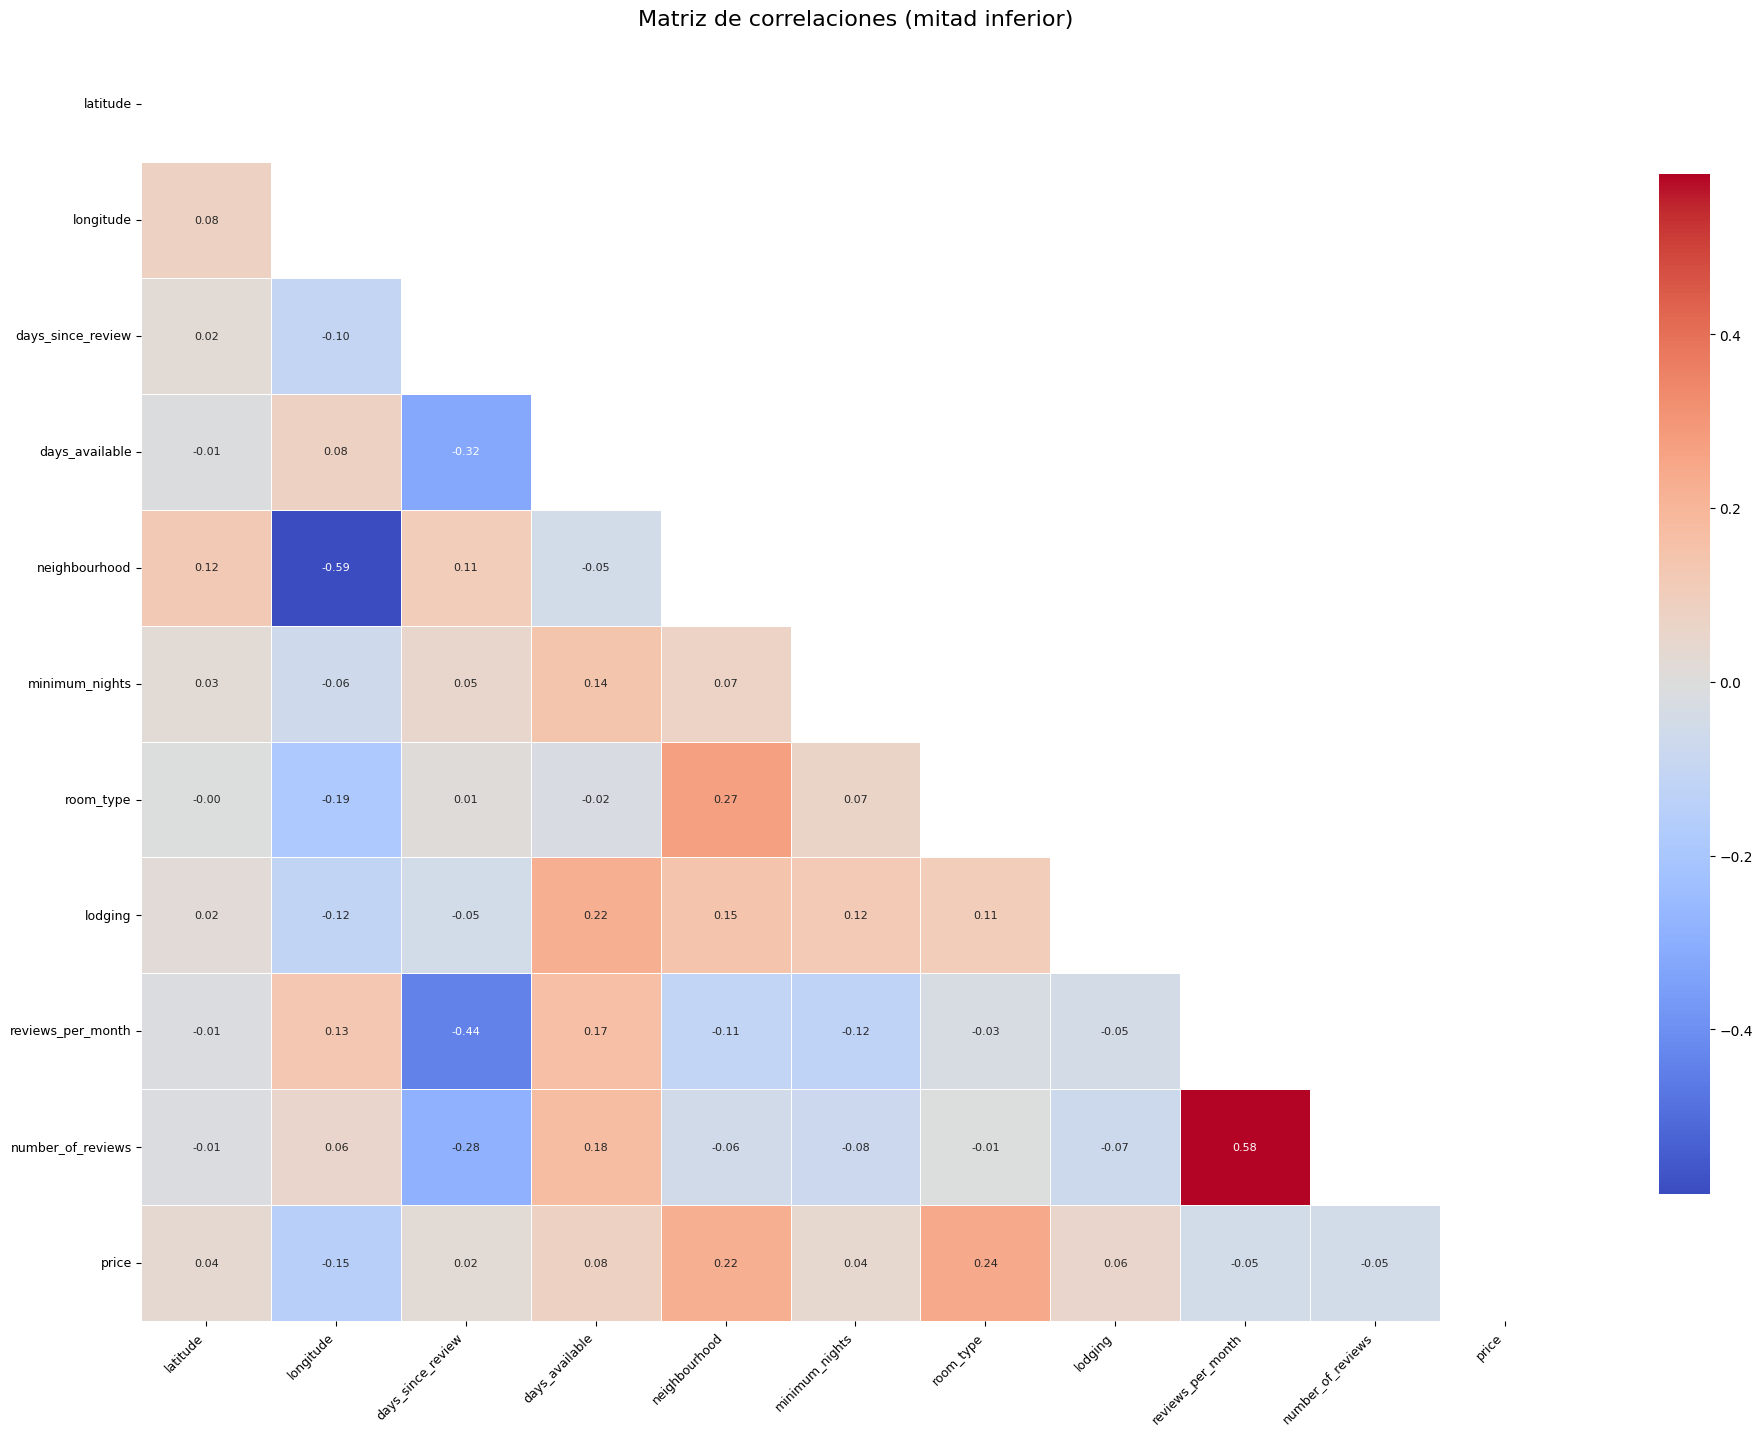

In [95]:
X_copy = X_train[features].copy()
X_copy['price'] = y_train
corr = X_copy.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 15))
sns.heatmap(
    corr, mask=mask, cmap='coolwarm',
    annot=True, fmt=".2f", linewidths=.5,
    cbar_kws={"shrink": .8},
    annot_kws={"size": 8}
)
plt.title("Matriz de correlaciones (mitad inferior)", fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout(pad=3.0)
plt.show()

En este caso, las variables que esta correlacionadas y que pueden presentar riesgo de colinealidad son:

- ``Neighbourhood`` con ``Longitude(Latitude)``

- ``Number_of_reviews`` con ``reviews_per_month``

## 2.4. Cross_validation

In [107]:
X_train

,host_prof,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,reviews_per_month,lodging,days_available,days_since_review
id,,,,,,,,,,,,
25674366,0,4,158,40.71577,-73.95530,3,3,11,0.87,1,1,55.0
19100971,0,5,86,40.84917,-73.94048,2,2,2,0.16,1,0,380.0
24209867,1,4,121,40.68993,-73.95947,2,2,0,0.00,2,0,NaN
22451798,0,4,121,40.68427,-73.93118,3,3,87,4.91,1,267,5.0
5344850,0,2,70,40.74705,-73.89564,2,5,13,0.25,1,0,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8754339,0,5,86,40.84650,-73.94319,1,1,0,0.00,1,0,NaN
34383329,0,5,206,40.73957,-74.00082,2,2,4,1.90,1,76,10.0
30109697,1,5,196,40.78318,-73.97372,3,30,1,0.34,5,261,89.0


In [122]:
# Versión 1: todas las características
cv_results1 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train[features], y_train, cv=4, scoring='neg_mean_absolute_error')

In [123]:
cv_results1.mean()

np.float64(-68.76705365664517)

In [ ]:
# Versión 2: todas las características
cv_results2 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train[features].drop(['neighbourhood','number_of_reviews'],axis=1), y_train, cv=3, scoring='neg_mean_absolute_percentage_error')

In [ ]:
cv_results2.mean()

### Relación 1

### Relación 2

<Axes: ylabel='price'>

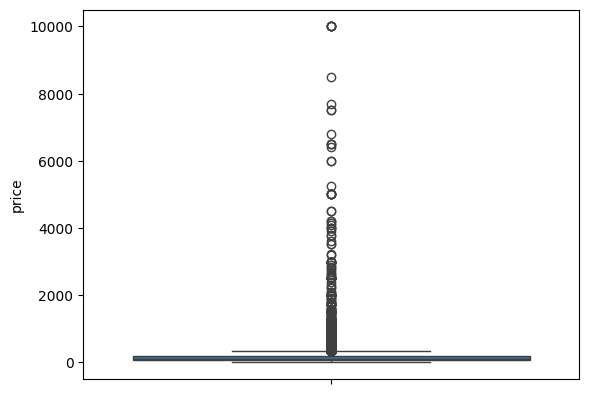

In [119]:
sns.boxplot(y_train)

#### Ajustamos la base de datos para desechar los outliers

[]

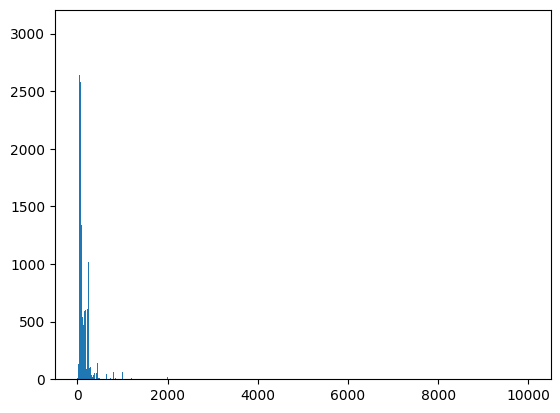

In [137]:
plt.hist(y_train, bins="auto") #[y_train<y_train.quantile(0.99)]
plt.plot()

In [124]:
y_train.describe()

count    39116.000000
mean       153.751585
std        247.037941
min          0.000000
25%         69.000000
50%        107.000000
75%        175.250000
max      10000.000000
Name: price, dtype: float64

In [139]:
df=df[(df["price"]>10)&(df['price'] <= 500)]
X = df.drop('price',axis=1)
y = df['price']

In [140]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42) #random_state establece una semilla para que la division aleatoria sea la misma

In [143]:
# Versión 1: todas las características
cv_results1 = cross_val_score(RandomForestRegressor(random_state=42,n_jobs=-1), X_train[features], y_train, cv=4, scoring='neg_mean_absolute_percentage_error')

In [144]:
cv_results1.mean()

np.float64(-0.3418624482425026)